# Implementing the BackPropagation in MiniFlow

# BackPropagation

#### MSE(Linear(Sigmoid(Linear(X, W1, b1)), W2, b2), y)


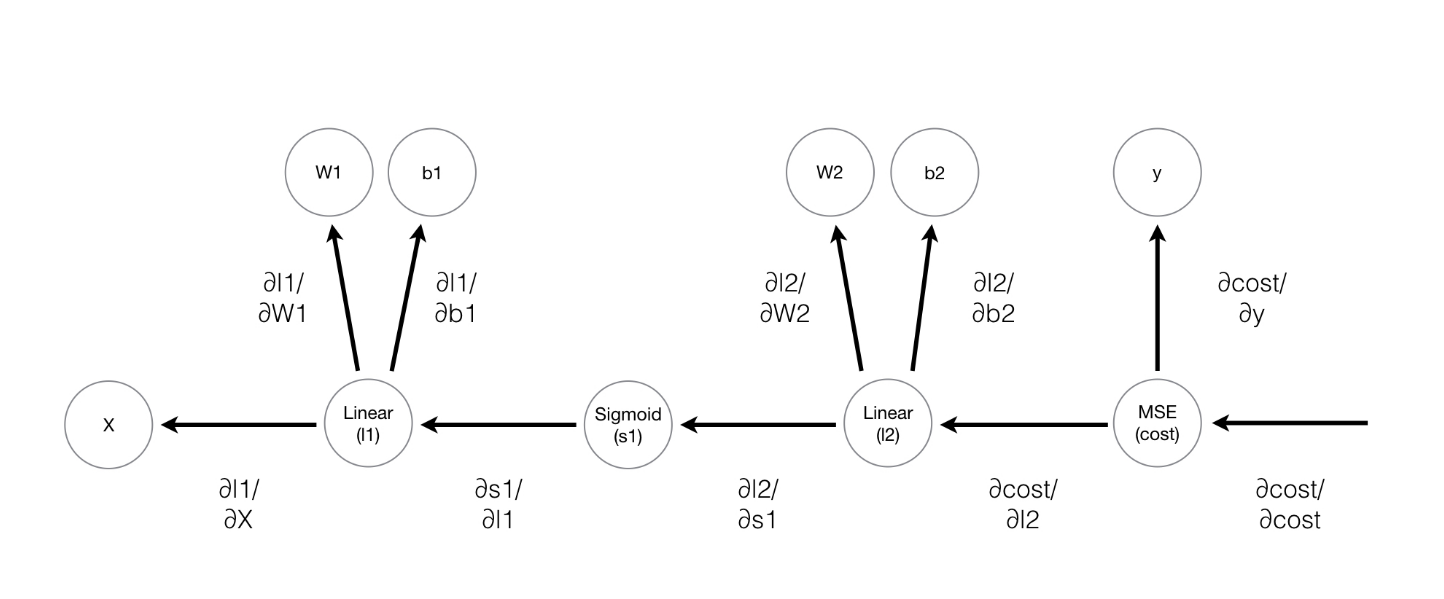

##### When computing the backward pass for a Node we only need to concern ourselves with the computation of that node w.r.t its inputs.
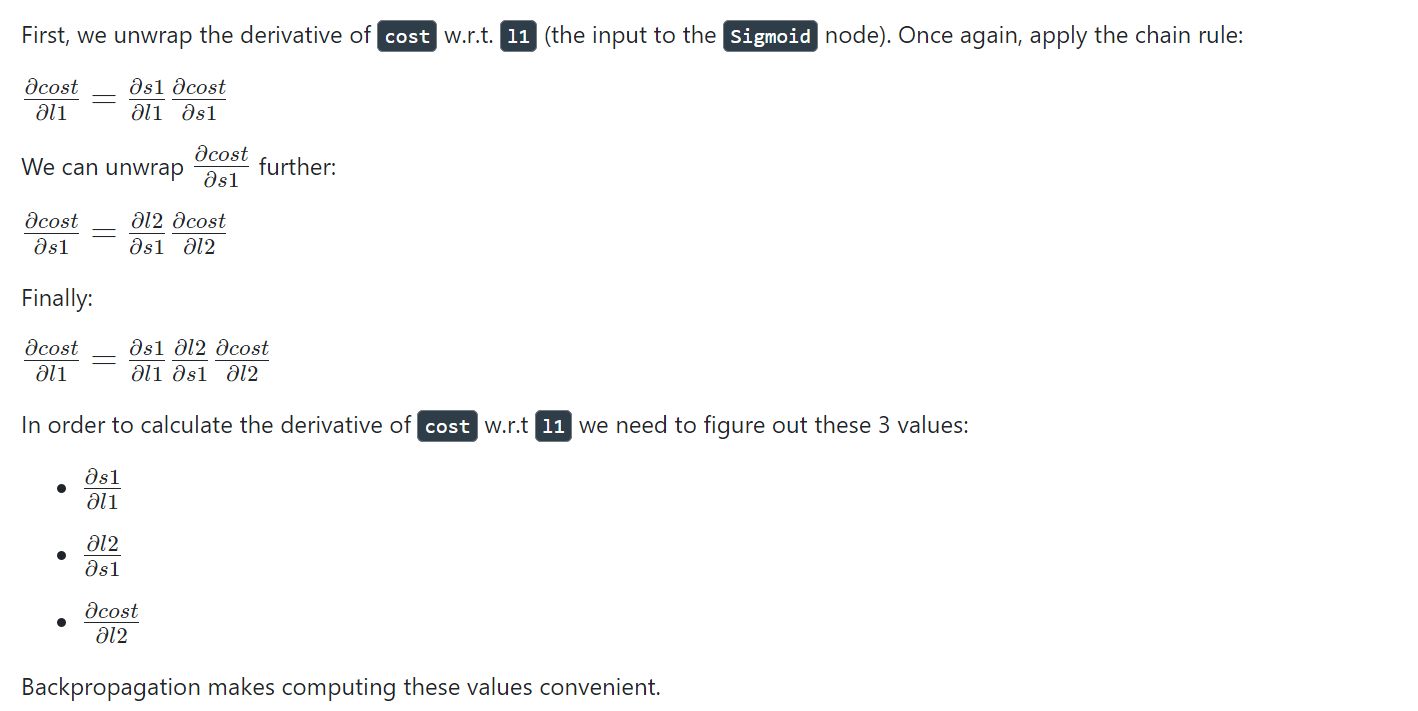

#### We will start from output node and travel backwards. Since we are differentiating our current node w.r.t to inbound nodes, so in back propagation method of current node we will take it's inbound nodes as key in gradient dictionary and set it's value as the differentiation of current node w.r.t to each corresponding inbound node multiplied by gradient of output node w.r.t to self ( According to chain rule)

Below our composite function is 

#### MSE(Sigmoid(Linear(X, W, b)), y)


In [5]:
class Node(object):
    """
    Base class for nodes in the network.

    Arguments:

        `inbound_nodes`: A list of nodes with edges into this node.
    """
    def __init__(self, inbound_nodes=[]):
        """
        Node's constructor (runs when the object is instantiated). Sets
        properties that all nodes need.
        """
        # A list of nodes with edges into this node.
        self.inbound_nodes = inbound_nodes
        # The eventual value of this node. Set by running
        # the forward() method.
        self.value = None
        # A list of nodes that this node outputs to.
        self.outbound_nodes = []
        # New property! Keys are the inputs to this node and
        # their values are the partials of this node with
        # respect to that input.
        self.gradients = {}
        # Sets this node as an outbound node for all of
        # this node's inputs.
        for node in inbound_nodes:
            node.outbound_nodes.append(self)

    def forward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `forward` method.
        """
        raise NotImplementedError

    def backward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `backward` method.
        """
        raise NotImplementedError
        
        
class Input(Node):
    def __init__ (self):
        Node.__init__(self,[])
        print("Inside Input Node: ",self)
        print("Inside Input Node: ",self.__dict__)
        print("\n")
        
    def forward(self):
        pass
    
    def backward(self):
        # An Input node has no inputs so the gradient (derivative)
        # is zero.
        # The key, `self`, is reference to this object.
        self.gradients = {self: 0}
        # Weights and bias may be inputs, so you need to sum
        # the gradient from output gradients.
        for n in self.outbound_nodes:
            grad_cost = n.gradients[self]
            self.gradients[self] += grad_cost * 1
        print("Input gradients: ",self.gradients)
        print("\n")


class Linear(Node):
    def __init__ (self,*args):
        Node.__init__(self,args)
        
        print("Inside Linear Node: ",self)
        print("Inside Linear Node: ",self.__dict__)
        print("\n")

            
    def forward(self):
        X = self.inbound_nodes[0].value
        W = self.inbound_nodes[1].value
        b = self.inbound_nodes[2].value
        self.value = np.dot(X,W) + b
        
    def backward(self):
        """
        Calculates the gradient based on the output values.
        """
        # Initialize a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        # Cycle through the outputs. The gradient will change depending
        # on each output, so the gradients are summed over all outputs.
        for n in self.outbound_nodes:
            # Get the partial of the cost with respect to this node.
            grad_cost = n.gradients[self]
            # Set the partial of the loss with respect to this node's inputs.
            self.gradients[self.inbound_nodes[0]] += np.dot(grad_cost, self.inbound_nodes[1].value.T)
            # Set the partial of the loss with respect to this node's weights.
            self.gradients[self.inbound_nodes[1]] += np.dot(self.inbound_nodes[0].value.T, grad_cost)
            # Set the partial of the loss with respect to this node's bias.
            self.gradients[self.inbound_nodes[2]] += np.sum(grad_cost, axis=0, keepdims=False)
        print("Linear gradients: ",self.gradients)
        print("\n")


class Sigmoid(Node):
    """
    Represents a node that performs the sigmoid activation function.
    """
    def __init__(self, node):
        # The base class constructor.
        Node.__init__(self, [node])
        print("Inside Sigmoid Node: ",self)
        print("Inside Sigmoid Node: ",self.__dict__)
        print("\n")


    def _sigmoid(self, x):
        """
        This method is separate from `forward` because it
        will be used with `backward` as well.

        `x`: A numpy array-like object.
        """
        return 1. / (1. + np.exp(-x))

    def forward(self):
        """
        Perform the sigmoid function and set the value.
        """
        input_value = self.inbound_nodes[0].value
        self.value = self._sigmoid(input_value)

    def backward(self):
        """
        Calculates the gradient using the derivative of
        the sigmoid function.
        """
        # Initialize the gradients to 0.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        # Sum the derivative with respect to the input over all the outputs.
        for n in self.outbound_nodes:
            grad_cost = n.gradients[self]
            sigmoid = self.value
            self.gradients[self.inbound_nodes[0]] += sigmoid * (1 - sigmoid) * grad_cost
        print("Sigmoid gradients: ",self.gradients)
        print("\n")

    
class MSE(Node):
    def __init__(self, y, a):
        """
        The mean squared error cost function.
        Should be used as the last node for a network.
        """
        # Call the base class' constructor.
        Node.__init__(self, [y, a])
        print("Inside MSE Node: ",self)
        print("Inside MSE Node: ",self.__dict__)
        print("\n")


    def forward(self):
        """
        Calculates the mean squared error.
        """
        # NOTE: We reshape these to avoid possible matrix/vector broadcast
        # errors.
        #
        # For example, if we subtract an array of shape (3,) from an array of shape
        # (3,1) we get an array of shape(3,3) as the result when we want
        # an array of shape (3,1) instead.
        #
        # Making both arrays (3,1) insures the result is (3,1) and does
        # an elementwise subtraction as expected.
        y = self.inbound_nodes[0].value.reshape(-1, 1)
        a = self.inbound_nodes[1].value.reshape(-1, 1)
        self.m = self.inbound_nodes[0].value.shape[0]

        self.diff = y - a
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        self.gradients[self.inbound_nodes[0]] = (2/self.m) * self.diff
        self.gradients[self.inbound_nodes[1]] = (-2/self.m) * self.diff
        print("MSE gradients: ",self.gradients)
        print("\n")
    

        
def topological_sort(feed_dict):
    """
    Sort the nodes in topological order using Kahn's Algorithm.

    `feed_dict`: A dictionary where the key is a `Input` Node and the value is the respective value feed to that Node.

    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outbound_nodes:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
        for m in n.outbound_nodes:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def forward_and_backward(graph):
    """
    Performs a forward pass and a backward pass through a list of sorted Nodes.

    Arguments:

        `graph`: The result of calling `topological_sort`.
    """
    print("Inside forward_and_backward graph:",graph)
    print("\n")

    # Forward pass
    for n in graph:
        n.forward()

    # Backward pass
    # see: https://docs.python.org/2.3/whatsnew/section-slices.html
    for n in graph[::-1]:
        n.backward()




In [6]:
"""
Test your network here!

No need to change this code, but feel free to tweak it
to test your network!

Make your changes to backward method of the Sigmoid class in miniflow.py
"""

import numpy as np
#from miniflow import *

X, W, b = Input(), Input(), Input()
y = Input()
f = Linear(X, W, b)
a = Sigmoid(f)
cost = MSE(y, a)

X_ = np.array([[-1., -2.], [-1, -2]])
W_ = np.array([[2.], [3.]])
b_ = np.array([-3.])
y_ = np.array([1, 2])

feed_dict = {
    X: X_,
    y: y_,
    W: W_,
    b: b_,
}

graph = topological_sort(feed_dict)
forward_and_backward(graph)
# return the gradients for each Input
gradients = [t.gradients[t] for t in [X, y, W, b]]

"""
Expected output

[array([[ -3.34017280e-05,  -5.01025919e-05],
       [ -6.68040138e-05,  -1.00206021e-04]]), array([[ 0.9999833],
       [ 1.9999833]]), array([[  5.01028709e-05],
       [  1.00205742e-04]]), array([ -5.01028709e-05])]
"""
print(gradients)


Inside Input Node:  <__main__.Input object at 0x000001E32CC0F220>
Inside Input Node:  {'inbound_nodes': [], 'value': None, 'outbound_nodes': [], 'gradients': {}}


Inside Input Node:  <__main__.Input object at 0x000001E32CC21790>
Inside Input Node:  {'inbound_nodes': [], 'value': None, 'outbound_nodes': [], 'gradients': {}}


Inside Input Node:  <__main__.Input object at 0x000001E32CC21D90>
Inside Input Node:  {'inbound_nodes': [], 'value': None, 'outbound_nodes': [], 'gradients': {}}


Inside Input Node:  <__main__.Input object at 0x000001E32CC0F670>
Inside Input Node:  {'inbound_nodes': [], 'value': None, 'outbound_nodes': [], 'gradients': {}}


Inside Linear Node:  <__main__.Linear object at 0x000001E32D079760>
Inside Linear Node:  {'inbound_nodes': (<__main__.Input object at 0x000001E32CC0F220>, <__main__.Input object at 0x000001E32CC21790>, <__main__.Input object at 0x000001E32CC21D90>), 'value': None, 'outbound_nodes': [], 'gradients': {}}


Inside Sigmoid Node:  <__main__.Sigmoi